# Text classification:

The process of categorizing text into pre-defined groups/classes
<img src="classification.png" width="600" align="left">

<br><br><br><br><br><br><br><br>
Organize unstructured text to extract value and get insights into:
    - social media messages
    - emails
    - online conversations (chat-bots)
    - websites
    
    
- **Applications** of automatic text classification:
    - Sentiment Analysis: understand the view / attitute / feeling / emotion toward a situation or event. We do text classification to analyze if a given text is talking positively or negatively about a given subject (e.g. pos/neg movie review). 

    - Topic Labeling: identify the theme or topic in the text (e.g. analyze the topics of news articles: entertainment, business, politics).

    - Spam Detection: detect whether an email is spam or not.



- **Approaches**:
    - manual
        - human annotator read and label the text
        - platform: AMT
        - pros: high quality
        - cons: time consuming and expensive  
        
    - automatic        
        - rule-based
            - pre-define a set of linguistic rules
            - instruct the system to use semantically relevant elements of a text to identify relevant categories based on its content
            - E.g., classify news article into sports and politics
                - sports-related keywords: football, basketball, LeBron James
                - politics-related keywords: government, Washington, Obama, Donald Trump, Hillary Clinton, etc.
            - cons: difficult and expensive to maintain

        - **machine learning-based**
            - train a classifier based on pre-labeled training data
            - apply the classifier to make predictions on new data
            - pros: fast, effective, accurate
            - cons: need pre-labeled training data


## Binary sentiment classification for IMDb movie reviews:

- IMDb: Internet Movie Database, is an online database of information related to films, television programs, and so on.
- Task: train a binary classification model to predict whether a movie review is positive or negative.

<img src="IMDb_review.png" width="600">

# Import libraries

In [2]:
import time, os

import numpy as np # linear algebra
import pandas as pd # data processing

import seaborn as sns # visualization
import matplotlib.pyplot as plt
%matplotlib inline

import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Load and explore the data
The data is available at this source, and you can learn more about how and why this dataset is created from this paper. <br>
Data source: https://ai.stanford.edu/~amaas/data/sentiment/ <br>
Paper: [Learning Word Vectors for Sentiment Analysis](https://ai.stanford.edu/~ang/papers/acl11-WordVectorsSentimentAnalysis.pdf) <br>

In [3]:
# we first download the data, and then use pandas dataframe to load the data from file
df_data = pd.read_csv('IMDB Dataset.csv')
df_data.shape, display(df_data.head())
# we can see there are 50,000 reviews, each review is either positive or negative

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


((50000, 2), None)

In [4]:
# this is an example of negative review
df_data.iloc[10].sentiment, df_data.iloc[10].review

('negative',
 'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"')

We then explore more about this data

In [5]:
# check empty cells
df_data.isnull().sum() 

review       0
sentiment    0
dtype: int64

In [6]:
# remove duplicate samples
df_data = df_data.drop_duplicates(keep="first")
df_data.shape
# compare with the original data 50,000, we removed about 500 duplicate samples

(49582, 2)

In [7]:
# check if pos and neg sentiments are balanced
df_data.sentiment.value_counts() 

positive    24884
negative    24698
Name: sentiment, dtype: int64

The dataset is equally distributed, which is great for building the model.

Now, lets check the length of the reviews

In [8]:
df_data['length'] = df_data['review'].apply(len) # number of characters
df_data['length'].describe() # info()
# the describe function shows the mean, std, min, max of length of the reviews

count    49582.000000
mean      1310.568230
std        990.762238
min         32.000000
25%        699.000000
50%        971.000000
75%       1592.000000
max      13704.000000
Name: length, dtype: float64

In [9]:
# we have a new column 'length' added to the dataframe
df_data.head()

,review,sentiment,length
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


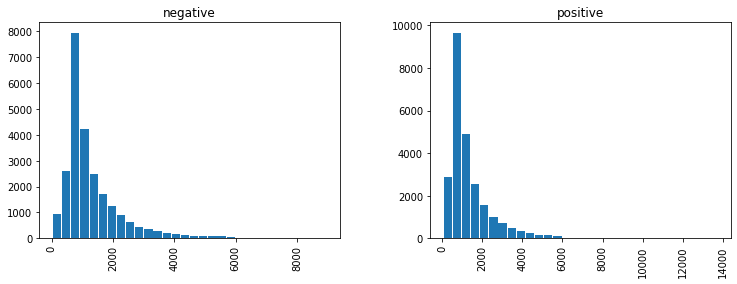

In [10]:
# plot the distribution of the length of positive and negative reviews
# x: length of reviews; y: number of reviews fall into each interval
df_data.hist(column='length', by='sentiment',bins=30, figsize=(12,4),rwidth=0.9)
plt.show()

Looking at the above distribution, we can say that there is no clear difference between postive and negative reviews based on the length of the review.

After the exploration, we now have a basic understanding of the dataset.
Lets go ahead to clean the reviews.

# Text Preprocessing 
There are many approaches for text preprocessing, such as:
- lowercasing
- data cleaning 
    > remove special characters, emails, urls <br>
    > remove stopwords <br>
    > remove punctuations <br>
        
- normalization
    > stemming 
        - chops off the ends of words to transform words into their root forms (e.g., connected->connect)
        - PorterStemmer, SnowballStemmer
    > lemmatization
        - map a word to its root form (dictionary, rule-based) based on the context, POS, intended meaning
        - WordNetLemmatizer
        - transforming a text into a standard form (abbreviations, misspellings, out-of-vocabulary words; e.g., gooood->good)
    > De-contract
        - expand the contracted words into normal words (I'm -> I am)

The specific steps to apply depends on your task. <br>
For our task of analyzing IMDb movie reviews data, we mainly focus on **data cleaning**, such as removing:

> HTML tags <br>
> special / non-alphabetic characters <br>
> url <br>
> emails <br>

In [11]:
# Here is an example of the review, we can see that ...
df_data.review[3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [12]:
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer

def decontracted(phrase):
    """
    We first define a function to expand the contracted phrase into normal words
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase) # prime 
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

def clean_text(df):
    """
    Clean the review texts
    """
    cleaned_review = []

    for review_text in tqdm(df['review']):
        
        # expand the contracted words
        review_text = decontracted(review_text)
        
        #remove html tags
        review_text = BeautifulSoup(review_text, 'lxml').get_text().strip() # re.sub(r'<.*?>', '', text)
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #remove url 
        review_text = re.sub(r'https?://\S+|www\.\S+', '', review_text)
        
        #Removing punctutation, string.punctuation in python consists of !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
        review_text = review_text.translate(str.maketrans('', '', string.punctuation))
        # ''.join([char for char in movie_text_data if char not in string.punctuation])
        
        # remove emails
        review_text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", '', review_text)
    
        cleaned_review.append(review_text)

    return cleaned_review

df_data['cleaned_review'] = clean_text(df_data)
# df_data['cleaned_review'] = df_data.apply(clean_text)
# df_data = df_data.drop(columns=['review'])

df_data.head()
# After the cleaning process, we get the cleaned_reviews

100%|██████████| 49582/49582 [00:25<00:00, 1949.39it/s]


,review,sentiment,length,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,1761,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,998,A wonderful little production The filming tec...
2,I thought this was a wonderful way to spend ti...,positive,926,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,748,Basically there is a family where a little boy...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,Petter Mattei is Love in the Time of Money i...


In [13]:
# example of a review before and after cleaning, we can see that the punctuations and html tags are removed.

print(df_data['review'][9],'\n')

print(df_data['cleaned_review'][9])

If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!! 

If you like original gut wrenching laughter you will like this movie  If you are young or old then you will love this movie  hell even my mom liked it Great Camp   


Before moving forward, we convert the sentiments to binary labels, the corresponding label for postive sentiment is 1 and 0 for negative.

In [14]:
df_data['label'] = df_data['sentiment'].map({'positive':1,'negative':0})
df_data.head()[['cleaned_review','sentiment','label']]

,cleaned_review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production The filming tec...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there is a family where a little boy...,negative,0
4,Petter Mattei is Love in the Time of Money i...,positive,1


# Feature Engineering

Feature engineering for text is the process of transforming raw texts into vector representations that the machine learning models can understand.

**Pipeline** for training a text classifier

<img src="training.png" width="800" align="center">


**Feature engineering techniques**:
- Units
    > words <br>
    > phrases <br>
    > POS tag <br>
- doc:
    > https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

- CountVectorizer 
    > represent document as a vector of word counts
- TfidfVectorizer 
    > term-frequency * inverse document-frequency
    > reduce very frequent terms (e.g., 'a', 'the', 'is')
- Embedding 
    > represent words into high-dimensional vectors
    > word2vec, BERT, GPT, ...

## Tools and packages for ML:
- **scikit-learn**: https://scikit-learn.org/stable/
- a free software machine learning library for Python 
- algorithms for:
    - feature engineering
    - classification
    - regression 
    - clustering
    - evaluation metric (e.g., precision, recall)

## CountVectorizer
- Convert a collection of text documents to a matrix of token counts
- doc: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
corpus = [
         'This is the first document.',
         'This document is the second document.',
         'And this is the third one.',
         'Is this the first document?',
        ]

In [31]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus) # Learn the vocabulary dictionary and return document-term matrix
print(X.toarray())
# columns represent features
# each row corresponds to a document

[[1 1 1 1 1]
 [2 0 1 1 1]
 [0 0 1 1 1]
 [1 1 1 1 1]]


In [22]:
print(type(X))
# print(X)
X

<class 'scipy.sparse.csr.csr_matrix'>


<4x9 sparse matrix of type '<class 'numpy.int64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [23]:
print(vectorizer.get_feature_names()) # Array mapping from feature integer indices to feature name

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']


In [24]:
vectorizer.vocabulary_ # A mapping from terms to feature indices

{'this': 8,
 'is': 3,
 'the': 6,
 'first': 2,
 'document': 1,
 'second': 5,
 'and': 0,
 'third': 7,
 'one': 4}

- ngrams as features

In [25]:
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X2 = vectorizer2.fit_transform(corpus)

print(X2.toarray())

[[0 0 1 1 0 0 1 0 0 0 0 1 0]
 [0 1 0 1 0 1 0 1 0 0 1 0 0]
 [1 0 0 1 0 0 0 0 1 1 0 1 0]
 [0 0 1 0 1 0 1 0 0 0 0 0 1]]


In [26]:
print(vectorizer2.get_feature_names())

['and this', 'document is', 'first document', 'is the', 'is this', 'second document', 'the first', 'the second', 'the third', 'third one', 'this document', 'this is', 'this the']


- Other important parameters:
    > min_df: ignore terms that have a document frequency lower than the given threshold <br>
    > max_df: ignore terms that have a document frequency lower than the given threshold(e.g., corpus-specific stop words) <br>
    > lowercase <br>
    > max_features <br>
    > vocabulary <br>
    > binary <br>

## TfidfVectorizer
- term-frequency * inverse document-frequency

- term-frequency: the number of times a term occurs in a given document

- Inverse document frequency:

<img src="idf.png" width="300" align="center">


- Euclidean norm:

<img src="euclidean_norm.png" width="500" align="center">

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
vectorizer = TfidfVectorizer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
X = vectorizer.fit_transform(corpus)
print(X.shape)
print(X.toarray())

(4, 9)
[[0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]
 [0.         0.6876236  0.         0.28108867 0.         0.53864762
  0.28108867 0.         0.28108867]
 [0.51184851 0.         0.         0.26710379 0.51184851 0.
  0.26710379 0.51184851 0.26710379]
 [0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]]


In [35]:
print(vectorizer.get_feature_names())

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']


In this task, we will use the **scikit-learn** implementation of [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to convert the movie reviews into a 2-d matrix.

In [62]:
# print(stopwords.words('english'))
#Exluding NO, NOR, NOT from the stop words as they play keyrole
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


# In the CountVectorizer, we ask it to lowercase the text, use a self-defined stopwords list to remove stopwords
# Will talk about how to tune these parameters later.
vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords, max_df=0.9, min_df=3, ngram_range=(1,1))

# convert the cleaned reviews to vectors
X = vectorizer.fit_transform(df_data.cleaned_review)
y = df_data.label.values

print("X.shape : ",X.shape)
print("y.shape : ",y.shape)

# X is the 2-d matrix of vector representation of the cleaned reviews
# y is the array of sentiment labels
# accoring to the shape of X, we can tell the number of samples, the number of features (size of vocabulary)

X.shape :  (49582, 47192)
y.shape :  (49582,)


# Train test split
Split the data into training and testing by 80:20 ratio after shuffling the data, assign a random state for reproducible output.

In [64]:
from sklearn.model_selection import train_test_split
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [65]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=42) # shuffle: re-arrange, randomize
print("Train shapes : X : {}, y : {}".format(X_train.shape,y_train.shape))
print("Test shapes : X : {}, y : {}".format(X_test.shape,y_test.shape))
# For example, after train test split, we get 39665 samples in the training set and 9917 in the testing set.

Train shapes : X : (39665, 47192), y : (39665,)
Test shapes : X : (9917, 47192), y : (9917,)


# Model Training

After we do text preprocessing, feature engineering, and train test split, the next step is model training, we need to decide which model to use. For example, there are:

- Logistic Regression
- Naive Bayes
- Decision Tree
- K-Nearest Neighbors
- Support Vector Machines
- (Deep) Neural Networks
- ... many many more

<img src="training_prediction.png" width="800" align="center">

## Logistic regression
In this task, we will use **Logistic regression**, which is one of the most popular and interpretable machine learning algorithm for binary classification.


**Linear Regression**: linear combination of independent variables,
$$
    t = \sum_{i} {\beta_i*x_i}
$$

**Logistic Regression**: regression with output constrained between 0 and 1 with a sigmoid logistic function, as we see here, combine the linear regression with a logistic function, we get the logistic regression function:
  
$$ 
    \hat{y} = \frac{1}{1 + \exp (- t)}  = \frac{1}{1 + \exp (-\sum_i\beta_i x_i)} 
$$

- $x_i$ is value of feature $i$ in an instance (count of a word)<br>
- $\beta_i$ is the real-valued model parameter associated with feature $i$ <br>
  - E.g., high $\beta_i$ means feature $i$ is predictive of positive class ($y=1$) <br>
- $\hat{y}$ is the probability of being positive, $y$ is the actual label <br>
    - If $\hat{y} > .5$, classify as positive, $y = 1$ <br>


<img src="Logistic_curve.png" width="400">

In [66]:
# fit a logistic regression classifier on the training data use default settings
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

# make prediction on testing data
y_pred_test = lr_clf.predict(X_test)

In [67]:
y_pred_test

array([0, 1, 0, ..., 0, 0, 0])